<a href="https://colab.research.google.com/github/PyMap/AUPY/blob/master/Modulo%201/01_2_Operaciones_espaciales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción al manejo de datos geográficos

# Geopandas II

## Operaciones espaciales

Los dataframes en geopandas no son otra cosa que una base de datos. Como las que venimos manipulando en pandas. Ahora bien, estas se distinguen por la presencia de un atributo que los dataframes comunes no cuentan: una `geometría`. Esta define tanto el tipo de objeto como las operaciones espaciales soportadas. 

Para cargar un geodataframe contamos con distintas alternativas. Podríamos leer un archivo de tipo `shp` como así también interpretar una geometría desde un cuerpo de texto o bien a partir de coordenadas geogŕaficas. 

### Polígonos, los barrios de la Ciudad desde WKT

In [1]:
import numpy as np

In [2]:
print(np.__version__)

1.21.1


In [3]:
try:
    import geopandas as gpd
except:
    !pip install geopandas
    !pip install rtree
    !sudo apt install libspatialindex-dev

Lo que hacemos en la siguiente sección, es interpretar una `geometría` desde el modulo well known text (wkt) de shapely. Digamos que estaríamos leyendo un archivo de tipo `shp` como si este fuera un `csv`.

In [4]:
import pandas as pd
from shapely import wkt

In [5]:
# este sería nuestro shapefile, con la serie "geometria" almacenada como objeto de tipo texto. 
barrios_wkt = pd.read_csv('https://raw.githubusercontent.com/PyMap/datahouse/main/caba/barrios_wkt.csv',
                          index_col=[0])

In [6]:
# vemos que la geometría se encuentra cargada como tipo object
barrios_wkt.str_geom.head()

0    POLYGON ((-58.4528200492791044 -34.59598865706...
1    POLYGON ((-58.4655768128540672 -34.59655770780...
2    POLYGON ((-58.4237529813036645 -34.59782733832...
3    POLYGON ((-58.4946097568899006 -34.61486523952...
4    POLYGON ((-58.4128700313088487 -34.61411625158...
Name: str_geom, dtype: object

In [7]:
# ahora, creamos una función para transformarla en geometría
def from_wkt(df, wkt_column, crs):
    '''
    Crea un geodataframe a partir de una columna de geometria de tipo object/string
    '''
    
    df["geometry"]= df[wkt_column].apply(wkt.loads) 
    gdf = gpd.GeoDataFrame(df, geometry='geometry',crs=crs) 
    
    return gdf

Antes de instanciar esta función en un nuevo geodataframe, reparemos en que aún no conocemos el sistema de coordenadas de referencia. Algo indispensable si queremos ajustar un elipsoide a un plano. Por lo que vemos en nuestra serie `str_geom`, algo podemos inferir. Por ejemplo, el formato de las coordenadas. Por el momento sólo mencionemos que contamos con dos sistemas de coordeandas. Los geográficos y los proyectados. 

In [8]:
# empecemos con un crs geográfico
from_wkt(barrios_wkt, 'str_geom', crs=4326).crs.is_geographic

True

<figure>
<center>
<img src='../imagenes/crs_tipo.png' />
<figcaption></figcaption></center>
</figure>

In [9]:
# tambien podemos reproyectar. Este epsg corresponde a la faja 6!, un CRS proyectado en dos dimensiones
from_wkt(barrios_wkt, 'str_geom', crs=4326).to_crs(22196).crs.is_projected

True

La Ciudad de Buenos Aires tiene su propio marco de referencia. Podemos utilizar un string con el formato [proj4](https://spatialreference.org/ref/sr-org/7124/proj4/) de la proyección [Gauss-Kruger BsAs](https://spatialreference.org/ref/sr-org/7124/) para definir reproyectar, una vez definido el CRS.

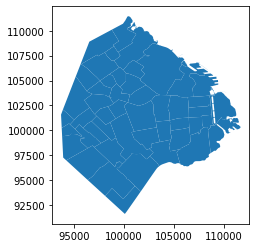

In [10]:
proj = '+proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs'
bsas_gk = from_wkt(barrios_wkt, 'str_geom', crs=4326).to_crs(proj)
bsas_gk.plot();

In [11]:
# observen la diferencia entre las geom texto y shapely. La primera en grados, y la ultima en mts.
bsas_gk.head()

,BARRIO,COMUNA,PERIMETRO,AREA,OBJETO,str_geom,geometry
0,CHACARITA,15.0,7724.852955,3.115707e+06,BARRIO,POLYGON ((-58.4528200492791044 -34.59598865706...,"POLYGON ((100906.371 103741.599, 100829.751 10..."
1,PATERNAL,15.0,7087.513295,2.229829e+06,BARRIO,POLYGON ((-58.4655768128540672 -34.59655770780...,"POLYGON ((99736.087 103678.512, 99732.116 1036..."
2,VILLA CRESPO,15.0,8131.857075,3.615978e+06,BARRIO,POLYGON ((-58.4237529813036645 -34.59782733832...,"POLYGON ((103572.860 103536.978, 103462.674 10..."
3,VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06,BARRIO,POLYGON ((-58.4946097568899006 -34.61486523952...,"POLYGON ((97073.311 101647.090, 97057.185 1016..."
4,ALMAGRO,5.0,8537.901368,4.050752e+06,BARRIO,POLYGON ((-58.4128700313088487 -34.61411625158...,"POLYGON ((104570.330 101729.514, 104575.182 10..."


In [12]:
bsas_gk.crs.is_projected

True

In [13]:
bsas_gk.crs

<Projected CRS: +proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k= ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: Unknown based on International 1924 (Hayford 1909, 1910) ellipsoid
- Ellipsoid: International 1924 (Hayford 1909, 1910)
- Prime Meridian: Greenwich

In [14]:
bsas_gk.crs.name

'unknown'

También, podemos acceder al atributo ̣[datum](https://es.wikipedia.org/wiki/Datum) de la clase `crs`. Este nos indica el modelo geodésico asociado (o elipsoide de referencia) en base al cual se define el sistema de coordenadas geográfico. 

Existen cientos de datum de referencia, cada uno desarrollado para referenciar puntos en áreas determinadas de la Tierra. De ahí, que un punto medido con diferentes datum pueda tener coordenadas diferentes. Entre los datum más comunes se encuentra WGS 84. 

Este sistema de coordenadas está expresado en grados, minutos, segundos y algo que vamos a hacer con mucha frecuencia es proyectarlo a un sistema cartesiano. Es decir, vamos a pasar de un modelo de 3 dimensiones a otro de 2. Este se conoce como sistema de proyección UTM. Estos están expresados en metros y los utilizaremos cada vez que necesitemos hacer operaciones que involucren cálculos de distancias o superficies. 

In [15]:
# acá el elipsoide de referencia para el sistema de coordenadas
bsas_gk.crs.datum

DATUM["Unknown based on International 1924 (Hayford 1909, 1910) ellipsoid",
    ELLIPSOID["International 1924 (Hayford 1909, 1910)",6378388,297,
        LENGTHUNIT["metre",1,
            ID["EPSG",9001]]]]

In [16]:
# bsas_gk no cuenta con ningun codigo epsg asociado
print(bsas_gk.crs.to_epsg())

None


En Argentina, datum de uso frecuente son POSGAR o Campo Inchause. Un listado más extenso en [la siguiente documentación provista por el Instituto Geográfico Nacional](https://ramsac.ign.gob.ar/posgar07_pg_web/documentos/Informe_sobre_codigos_oficiales_EPSG.pdf). Ambos, en grados.

In [17]:
# POSGAR 07
bsas_gk.to_crs(5340).crs.is_geographic

True

In [18]:
# CAMPO INCHAUSE
bsas_gk.to_crs(4221).crs.is_geographic

True

### Puntos, las estaciones de Ecobici ...

En el paso anterior, creamos un geodataframe cuya geoemtría principal eran polígonos. Ahora, vamos a hacer algo similar aunque con otro tipo de geometría. Vamos a levantar un geodataframe de puntos, con la ubicación de las estaciones EcoBici a partir de coordeandas x e y específicas.

In [19]:
# leemos el csv
estaciones = pd.read_csv('https://raw.githubusercontent.com/PyMap/datahouse/main/ecobici/nuevas-estaciones-bicicletas-publicas.csv')

In [20]:
estaciones.sample(4)

,lat,long,nombre_estacion,id_estacion,capacidad,dirección_completa,direccion_nombre,direccion_altura,direccion_interseccion,barrio
170,-34.559793,-58.448432,255 - BARRANCAS DE BELGRANO,289,24,"Sucre, Antonio Jose De, Mcal. Y Vertiz Virrey Av.","Sucre, Antonio Jose De, Mcal. Y Vertiz Virrey Av.",NaN,NaN,Belgrano
71,-34.630374,-58.395852,107 - HOSPITAL GARRAHAN,107,16,Brasil & Pichincha,Brasil,NaN,Pichincha,Parque patricios
161,-34.577296,-58.457854,260 - SAN MIGUEL DE GARICOITS,269,18,"Delgado & Loreto, Virrey",Delgado,NaN,"Loreto, Virrey",Colegiales
74,-34.594974,-58.372255,114 - DELLA PAOLERA,114,20,"Della Paolera 297, Carlos M. & Av. Leandro N. ...","Della Paolera 297, Carlos M.",297.0,Av. Leandro N. Alem,Retiro


In [21]:
from shapely.geometry import Point

In [22]:
list(zip(estaciones['long'], estaciones['lat']))

[(-58.3747151, -34.5924233),
 (-58.3682604, -34.611032),
 (-58.3687628, -34.6017255),
 (-58.4209542, -34.5805497),
 (-58.369758, -34.628526),
 (-58.381098, -34.606498),
 (-58.3893364, -34.6094218),
 (-58.407741, -34.585443),
 (-58.388807, -34.5927096),
 (-58.406, -34.61009),
 (-58.426387, -34.577424),
 (-58.4187306, -34.6064101),
 (-58.4417756, -34.5798619),
 (-58.406432, -34.640111),
 (-58.3825498, -34.5938629),
 (-58.379836, -34.600139),
 (-58.3808943, -34.610583),
 (-58.4161178, -34.5894269),
 (-58.3638723, -34.600752),
 (-58.3900887, -34.599068),
 (-58.4335573, -34.6079414),
 (-58.3973698, -34.5908211),
 (-58.3735984, -34.6072074),
 (-58.3989807, -34.5970909),
 (-58.371847, -34.5964246),
 (-58.3828403, -34.5970497),
 (-58.4076348, -34.6364511),
 (-58.3800307, -34.6046074),
 (-58.3900194, -34.583918),
 (-58.4138829, -34.5755148),
 (-58.3866934, -34.6018635),
 (-58.3743749, -34.6163012),
 (-58.362004, -34.623937),
 (-58.4010798, -34.5837348),
 (-58.3821261, -34.6014776),
 (-58.421984

In [23]:
def point_from_coord(df, x, y, crs):
  '''
  Carga un geodataframe de puntos a partir de un par de coordenadas lat/lon
  '''
  df['coordenadas'] = list(zip(df[x], df[y]))
  df['geometry'] = df['coordenadas'].map(Point)
  df_sin_coord = df.drop(columns=['coordenadas',x,y])
  gdf = gpd.GeoDataFrame(df_sin_coord, geometry='geometry', crs=crs) 

  return gdf

In [24]:
# creamos el gdf de estaciones
gdf = point_from_coord(estaciones, 'long', 'lat', 4326)

In [25]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

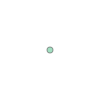

In [26]:
gdf.geometry.iloc[2]

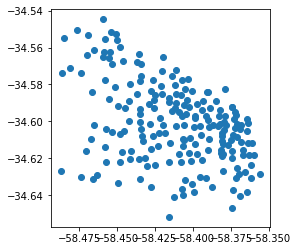

In [27]:
# ahora si, un gdf de puntos
gdf.plot();

In [28]:
# acá, otra forma de crear un geodataframe de puntos a partir de un conjunto de coordenadas
gdf_test = gpd.GeoDataFrame(estaciones, crs=4326, 
                            geometry=gpd.points_from_xy(estaciones['long'], estaciones['lat']))

In [29]:
gdf_test.head(2)

,lat,long,nombre_estacion,id_estacion,capacidad,dirección_completa,direccion_nombre,direccion_altura,direccion_interseccion,barrio,coordenadas,geometry
0,-34.592423,-58.374715,002 - Retiro I,2,20,"Ramos Mejia, Jose Maria, Dr. Av. & Del Liberta...","Ramos Mejia, Jose Maria, Dr. Av.",NaN,Del Libertador Av.,Retiro,"(-58.3747151, -34.5924233)",POINT (-58.37472 -34.59242)
1,-34.611032,-58.368260,003 - ADUANA,3,20,Moreno & Av Paseo Colon,Moreno,NaN,Av Paseo Colon,Monserrat,"(-58.3682604, -34.611032)",POINT (-58.36826 -34.61103)


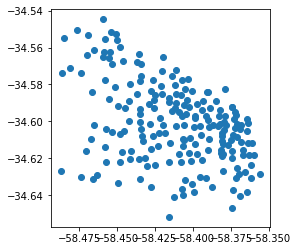

In [30]:
gdf_test.plot();

Ahora que construimos nuestros geodataframes, veamos cómo se ven en un **eje único (superponiendo capas)**.

In [31]:
barrios_proj = from_wkt(barrios_wkt, 'str_geom', crs=4326).to_crs(proj)
estaciones_proj = point_from_coord(estaciones, 'long', 'lat', 4326).to_crs(proj)

In [32]:
import matplotlib.pyplot as plt

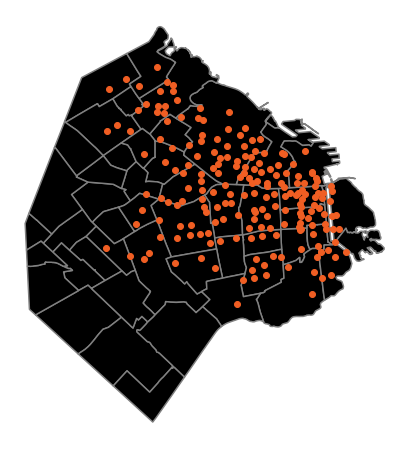

In [33]:
fig, ax = plt.subplots(figsize=(12,8))

barrios_proj.plot(ax=ax, color='black', edgecolor='grey', linewidth=1.5)

estaciones_proj.plot(ax=ax, color='#F05E23')
ax.set_axis_off();

In [34]:
estaciones.sample(3)

,lat,long,nombre_estacion,id_estacion,capacidad,dirección_completa,direccion_nombre,direccion_altura,direccion_interseccion,barrio,coordenadas,geometry
33,-34.583735,-58.401080,050 - Hospital Rivadavia,50,20,2516 Pereyra Lucena,Pereyra Lucena,2516.0,NaN,Palermo,"(-58.4010798, -34.5837348)",POINT (-58.4010798 -34.5837348)
18,-34.600752,-58.363872,026 - JUANA MANSO I,26,24,"Manso Juana & De La Barra, Emma",Manso Juana,NaN,"De La Barra, Emma",Puerto madero,"(-58.3638723, -34.600752)",POINT (-58.3638723 -34.600752)
83,-34.592106,-58.374542,130 - RETIRO II,130,40,"Ramos Mejia, Av Dr Jose Maria Vargas& Av. Del ...","Ramos Mejia, Av Dr Jose Maria Vargas& Av. Del ...",NaN,Av. Del Libertador,Retiro,"(-58.3745419, -34.5921056)",POINT (-58.3745419 -34.5921056)


In [35]:
# carguemos un dataset de recorridos. Este, para 2018
df = pd.read_csv('https://storage.googleapis.com/python_mdg/data_cursos/bici18_cdn.csv')

In [36]:
df.sample(3)

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad
2404976,486688.0,2018-04-24 21:19:35,32.0,Virrey Cevallos,183,Virrey Cevallos,183.0,MASCULINO,68.0
319882,441187.0,2018-11-13 11:20:11,12.0,Facultad de Psicologia,169,Congreso II,39.0,MASCULINO,33.0
2947578,258789.0,2018-01-06 12:04:00,11.0,Julián Álvarez,65,Acuña de Figueroa,54.0,FEMENINO,30.0


In [37]:
# Creamos la cantidad total de retiros en origen para el año 2018
retiros_en_origen = df.groupby(['bici_nombre_estacion_origen',
                                'bici_estacion_origen'])[['bici_sexo']].count().reset_index()

In [38]:
retiros_en_origen

,bici_nombre_estacion_origen,bici_estacion_origen,bici_sexo
0,15 de Noviembre,105,4966
1,25 de Mayo,60,11750
2,9 de Julio,112,8363
3,Acevedo,136,16853
4,Acuña de Figueroa,54,24843
...,...,...,...
196,Vera Peñaloza,150,26708
197,Villarroel,158,8722
198,Virrey Cevallos,183,25584
199,Virrey Liniers,139,8544


In [39]:
# ... y lo mergeamos con nuestro shape de estaciones
retiros_en_origen_map = pd.merge(estaciones_proj,retiros_en_origen, 
                                 left_on='id_estacion', 
                                 right_on='bici_estacion_origen')

In [40]:
retiros_en_origen_map

,nombre_estacion,id_estacion,capacidad,dirección_completa,direccion_nombre,direccion_altura,direccion_interseccion,barrio,geometry,bici_nombre_estacion_origen,bici_estacion_origen,bici_sexo
0,002 - Retiro I,2,20,"Ramos Mejia, Jose Maria, Dr. Av. & Del Liberta...","Ramos Mejia, Jose Maria, Dr. Av.",NaN,Del Libertador Av.,Retiro,POINT (108071.943 104133.650),Retiro,2,17426
1,003 - ADUANA,3,20,Moreno & Av Paseo Colon,Moreno,NaN,Av Paseo Colon,Monserrat,POINT (108662.180 102068.743),Aduana,3,6756
2,004 - Plaza Roma,4,20,Lavalle & Bouchard,Lavalle,NaN,Bouchard,San nicolas,POINT (108617.061 103101.211),Plaza Roma,4,14935
3,005 - Plaza Italia,5,42,Av. Sarmiento 2601,Av. Sarmiento,2601.0,NaN,Palermo,POINT (103830.403 105453.581),Plaza Italia,5,35698
4,006 - Parque Lezama,6,20,"Avenida Martin Garcia, 295","Avenida Martin Garcia,",295.0,NaN,San telmo,POINT (108523.029 100128.153),Parque Lezama,6,15010
...,...,...,...,...,...,...,...,...,...,...,...,...
122,194 - PERÓN Y ACUÑA DE FIGUEROA,194,16,3997 TTE. GENERAL JUAN DOMINGO PERON,TTE. GENERAL JUAN DOMINGO PERON,3997.0,NaN,Almagro,POINT (103690.787 102621.882),Peron y F. Acuña de Figueroa,194,15645
123,196 - HOSPITAL ARGERICH,196,20,750 Pi Y Margall & Necochea,750 Pi Y Margall,750.0,Necochea,Boca,POINT (108893.329 100237.731),Hospital Argerich,196,5251
124,197 - Quintino Bocayuva,197,20,Quintino Bocayuva y Don Bosco,Quintino Bocayuva y Don Bosco,NaN,NaN,Almagro,POINT (103604.850 101803.963),Quintino Bocayuva,197,12281
125,199 - ESTADOS UNIDOS Y BOEDO,199,20,3568 Estados Unidos & Boedo Av.,3568 Estados Unidos,3568.0,Boedo Av.,Boedo,POINT (104281.579 100826.205),EEUU y Boedo,199,17004


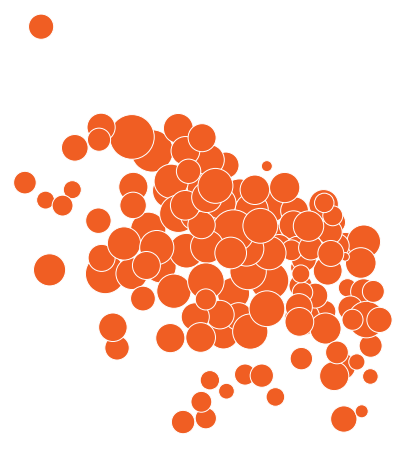

In [41]:
# un primer pantallazo de nuestras estaciones, graduadas por cantidad de viajes
fig, ax =plt.subplots(figsize=(15,8))
retiros_en_origen_map.plot(ax=ax, 
                           markersize=retiros_en_origen_map['bici_sexo']*0.05, 
                           color='#F05E23', edgecolor='white')
ax.set_axis_off();

Veamos ahora cómo superponer nuevamente ambas capas, pero esta vez en ejes que no están superpuestos. Armemos algo que nos permita ver las estaciones graduadas por cantidad de viajes, pero en barrios específicos.

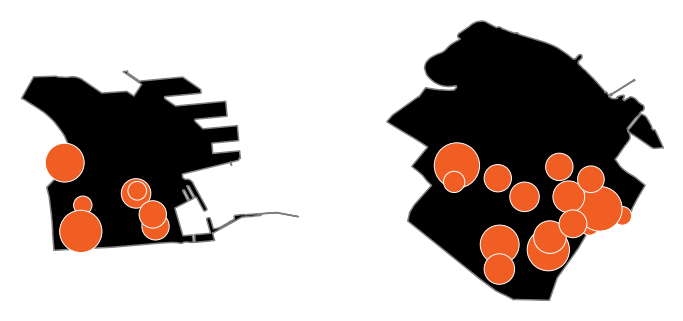

In [42]:
# por ejemplo para Retiro y Palermo
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# barrio 1
barrios_proj.loc[barrios_proj['BARRIO']=='RETIRO'].plot(ax=ax1, color='black', 
                                                        edgecolor='grey', linewidth=1.5)
retiros_en_origen_map.loc[retiros_en_origen_map['barrio']=='Retiro'].plot(ax=ax1, 
                                                                          markersize=retiros_en_origen_map['bici_sexo']*0.05, 
                                                                          color='#F05E23', edgecolor='white')

#barrio 2
barrios_proj.loc[barrios_proj['BARRIO']=='PALERMO'].plot(ax=ax2, color='black', 
                                                         edgecolor='grey', linewidth=1.5)
retiros_en_origen_map.loc[retiros_en_origen_map['barrio']=='Palermo'].plot(ax=ax2, 
                                                                           markersize=retiros_en_origen_map['bici_sexo']*0.05, 
                                                                           color='#F05E23', edgecolor='white')

ax1.set_axis_off()
ax2.set_axis_off();

# Operaciones geográficas 

El análisis espacial, muchas veces nos demanda realizar distintos tipos de manipulaciones sobre geometrías u objetos espaciales. Por ejemplo, podríamos necesitar recortar una capa en función de otra base, agregar etiquetas provenientes de capas de superposición, ver delimitaciones establecidas entre dos o más capas que intersectan, etc, etc.

Esto, con la finalidad de de responder preguntas específicas. Por ejemplo, imaginemos que necesitamos conocer la cantidad de retiros de bicicletas a un nivel de agregación mayor. Digamos, comunas.

> **join espacial**

GeoPandas permie, así como Pandas, realizar joins según columnas, a través de **merge** o **join**. Además, GeoPandas agrega la posibilidad de unir dos GeoDataFrames según una operación espacial. El método a emplear es **.sjoin** que tiene dos parámetros importantes: 

- how: que permite establecer si es un *left*, un *right* o un *inner*.

- op: consta de 3 operaciones geográficas:

    **intersects (interseca)**: los atributos se van a joinear si el límite o el interior de un objeto (geográfico) se interseca con el límite o el interior del otro objeto geográfico.
    
    **within (dentro)**: los atributos se van a joinear si el límite o el interior de un objeto (geográfico) se interseca sólo con el interior del otro objeto geográfico.

    **contains (contiene)**: los atributos se van a joinear si el interior del objeto contiene la frontera y el interior del otro objeto y sus límites no se tocan.


Puede consultarse la documentación en: http://geopandas.org/mergingdata.html

In [43]:
comunas = gpd.read_file('https://storage.googleapis.com/python_mdg/carto_cursos/comunas.zip')

In [44]:
# Primero veamos en qué coordenadas están las capas que queremos unir
comunas.crs == retiros_en_origen_map.crs

False

In [45]:
# Es el mismo? podemos realizar la operación con tranquilidad?
retiros_comuna = gpd.sjoin(retiros_en_origen_map, comunas, how='left', op='within')

/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k= ...
Right CRS: PROJCS["Argentina_GKBsAs",GEOGCS["Campo Inchauspe" ...

  


In [46]:
# reproyectemos!
retiros_comuna = gpd.sjoin(retiros_en_origen_map, comunas.to_crs(proj), how='left', op='within')

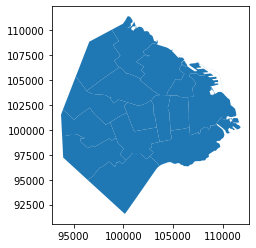

In [47]:
comunas.plot();

In [48]:
comunas

,BARRIOS,PERIMETRO,AREA,COMUNAS,ID,OBJETO,geometry
0,RECOLETA,21452.838648,6.317265e+06,2.0,1,LIMITE COMUNAL,"POLYGON ((107643.458 106569.299, 107641.492 10..."
1,ALMAGRO - BOEDO,12323.432479,6.660603e+06,5.0,2,LIMITE COMUNAL,"POLYGON ((104625.143 101679.935, 104629.994 10..."
2,CABALLITO,10990.964471,6.851029e+06,6.0,3,LIMITE COMUNAL,"POLYGON ((102998.760 102464.802, 103002.947 10..."
3,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,7.0,4,LIMITE COMUNAL,"POLYGON ((101036.604 99947.208, 101075.002 998..."
4,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,9.0,5,LIMITE COMUNAL,"POLYGON ((94869.346 99583.645, 94885.072 99583..."
5,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,10.0,6,LIMITE COMUNAL,"POLYGON ((97703.854 101010.270, 97716.104 1009..."
6,VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL....,19987.696155,1.412004e+07,11.0,7,LIMITE COMUNAL,"POLYGON ((96781.486 103649.395, 96892.479 1035..."
7,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,17232.189372,1.557093e+07,12.0,8,LIMITE COMUNAL,"POLYGON ((96329.447 103927.833, 96314.729 1039..."
8,PALERMO,22126.531858,1.584587e+07,14.0,9,LIMITE COMUNAL,"POLYGON ((103353.744 108568.622, 103353.843 10..."
9,BALVANERA - SAN CRISTOBAL,10486.260809,6.385991e+06,3.0,10,LIMITE COMUNAL,"POLYGON ((104713.283 103467.380, 104862.315 10..."


In [49]:
retiros_comuna.COMUNAS

0       1.0
1       1.0
2       1.0
3      14.0
4       1.0
       ... 
122     5.0
123     4.0
124     5.0
125     5.0
126     2.0
Name: COMUNAS, Length: 127, dtype: float64

Esta operación nos permitiría comparar tanto la cantidad de retiros entre polígonos (puntos graduados) como dentro de los mismos (choropletas). Veamos el primer caso ...

In [50]:
def compara_retiros_totales(comuna_a, comuna_b):
    '''
    Compara cantidad de retiros totales en estaciones de origen
    ...
    Argumentos:
        comuna_a (int): id de la primera comuna
        comuna_b (int): id de la segunda comuna 
    Devuelve:
        matplotlib.axes: mapas de superpisicion en dos ejes
    '''
    fig = plt.figure(figsize=(17,12))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    # comuna a
    comunas.loc[comunas.COMUNAS == comuna_a].plot(ax=ax1, color='black', edgecolor='grey', linewidth=1.5)
    retiros_comuna.loc[retiros_comuna.COMUNAS == comuna_a].plot(ax=ax1, color='red', 
                                                                edgecolor='white',
                                                                markersize=retiros_comuna['bici_sexo']*0.05).plot()

    # comuna b
    comunas.loc[comunas.COMUNAS == comuna_b].plot(ax=ax2, color='black', edgecolor='grey', linewidth=1.5)
    retiros_comuna.loc[retiros_comuna.COMUNAS == comuna_b].plot(ax=ax2, color='green', 
                                                                edgecolor='white', 
                                                                markersize=retiros_comuna['bici_sexo']*0.05).plot()

    ax1.set_title('Retiros en origen:Comuna {}'.format(comuna_a))
    ax1.set_axis_off()

    ax2.set_title('Retiros en origen:Comuna {}'.format(comuna_b))
    ax2.set_axis_off();

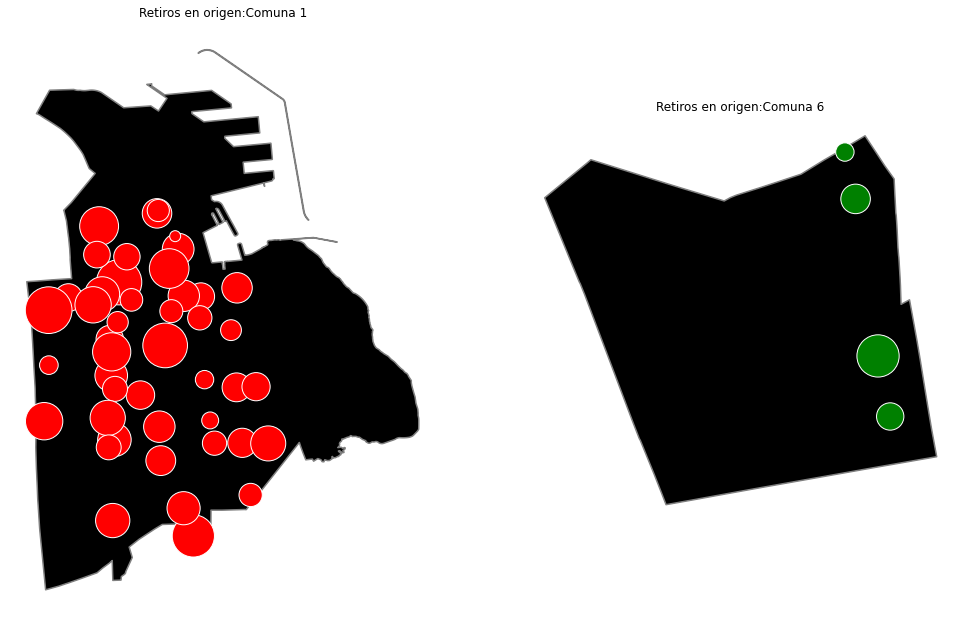

In [51]:
compara_retiros_totales(comuna_a=1, comuna_b=6)

In [52]:
comunas_agregacion = retiros_comuna.groupby(['COMUNAS'])[['bici_sexo']].sum().reset_index()
retiros_por_comuna = pd.merge(comunas, comunas_agregacion[['COMUNAS','bici_sexo']], 
                              how='left', on='COMUNAS')

In [53]:
!pip install mapclassify

In [54]:
retiros_por_comuna.fillna(0, inplace=True)

In [55]:
# retiros anuales totales por comuna
retiros_por_comuna.head()

,BARRIOS,PERIMETRO,AREA,COMUNAS,ID,OBJETO,geometry,bici_sexo
0,RECOLETA,21452.838648,6.317265e+06,2.0,1,LIMITE COMUNAL,"POLYGON ((107643.458 106569.299, 107641.492 10...",375303.0
1,ALMAGRO - BOEDO,12323.432479,6.660603e+06,5.0,2,LIMITE COMUNAL,"POLYGON ((104625.143 101679.935, 104629.994 10...",154197.0
2,CABALLITO,10990.964471,6.851029e+06,6.0,3,LIMITE COMUNAL,"POLYGON ((102998.760 102464.802, 103002.947 10...",74271.0
3,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,7.0,4,LIMITE COMUNAL,"POLYGON ((101036.604 99947.208, 101075.002 998...",0.0
4,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,9.0,5,LIMITE COMUNAL,"POLYGON ((94869.346 99583.645, 94885.072 99583...",0.0


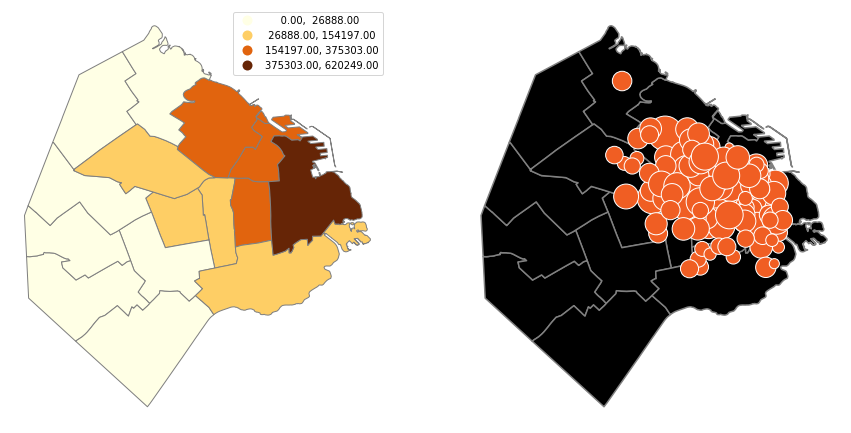

In [56]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

retiros_por_comuna.plot(ax=ax1, column='bici_sexo', 
                        cmap='YlOrBr', edgecolor='grey', 
                        scheme='NaturalBreaks', k=4, legend=True)

comunas.plot(ax=ax2, color='black', edgecolor='grey', linewidth=1.5)
retiros_en_origen_map.plot(ax=ax2,  
                           markersize=retiros_en_origen_map['bici_sexo']*0.03, 
                           #column='bici_sexo', legend=True,
                           color='#F05E23', 
                           edgecolor='white')

ax1.set_axis_off()
ax2.set_axis_off();

> **Overlay y Dissolve**

Otra pregunta que podríamos llegar a querer respondernos es cuál es el área de cobertura del servicio. Supongamos que para poder hacerlo, establecemos como parámetro un buffer de cierta distancia a las estaciones de ecobici. Así, podremos determinar un patrón de cobertura. Esto, combinando los radios de cobertura que se intersectan y determinando el área de la geometría resultante. Para ello, nos valdremos de dos operaciones comunmente utilizadas, el overlay y el dissolve. Dos métodos que se encuentran implementados en geopandas de una manera bastante clara. 

In [57]:
estaciones_buff = estaciones_proj.copy()
# dado que las estaciones se encuentran bastante concentradas, definamos un buffer de corto alcance
estaciones_buff.geometry = estaciones_buff.buffer(300) 

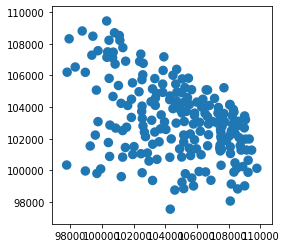

In [58]:
estaciones_buff.plot();

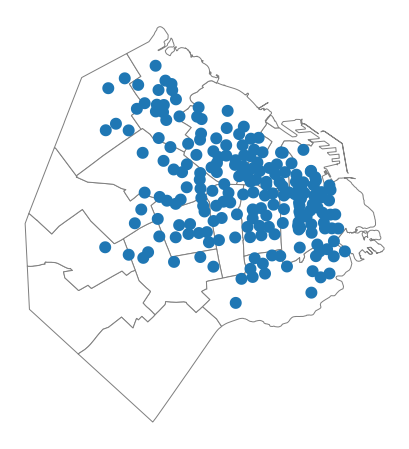

In [59]:
fig, ax = plt.subplots(figsize=(15,8))

comunas.plot(ax=ax, color='white', edgecolor='grey', linewidth=1)
estaciones_buff.plot(ax=ax)

ax.set_axis_off();

Ahora vamos a ver cómo calcular el área cubierta y el área no cubierta. El área cubierta es la **intersección** entre la capa de barrios y la capa de estaciones (con su buffer). Por otro lado, el área no cubierta es la **diferencia** entre la capa de barrios y la capa de bomberos (con su buffer).

In [60]:
interseccion = gpd.overlay(estaciones_buff, comunas.to_crs(proj), how = "intersection")

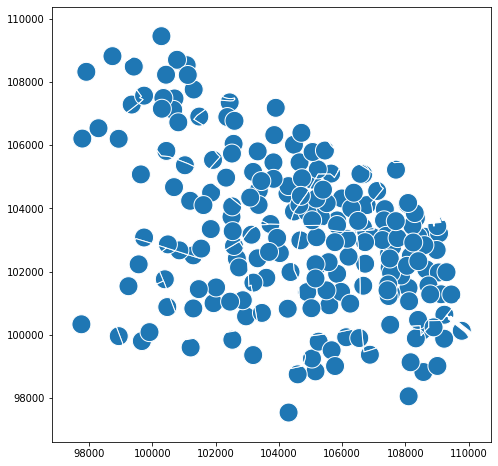

In [61]:
interseccion.plot(figsize=(15,8), edgecolor='white');

In [62]:
# ahora, podemos ver el área de intersección entre buffers
interseccion.geometry.area

0      282289.364149
1      282289.364149
2      282289.364149
3       99031.633529
4      282289.364149
           ...      
261     23211.882802
262    282289.364149
263     76290.340177
264    161067.296948
265    282289.364149
Length: 266, dtype: float64

Sin embargo, como podemos verlos buffer se superponen, lo que nos estaría haciendo incurrir en el error de contar más de una vez áreas de cobertura. Por eso, debemos primer unir todos los polígonos para evitar errores de duplicación.

Acá es donde entra el método `dissolve`. Este método unifica geometrías bajo una constante. Primero, vamos a generar un agrupamiento para calcular el área de cobertura en toda la Ciudad. Lógicamente, esta lógica se podría replicar para grupos de comunas, haciendo el filtrado correspondiente.

In [63]:
# creamos una constante
interseccion["const"] = 0

In [64]:
interseccion.head()

,nombre_estacion,id_estacion,capacidad,dirección_completa,direccion_nombre,direccion_altura,direccion_interseccion,barrio,BARRIOS,PERIMETRO,AREA,COMUNAS,ID,OBJETO,geometry,const
0,002 - Retiro I,2,20,"Ramos Mejia, Jose Maria, Dr. Av. & Del Liberta...","Ramos Mejia, Jose Maria, Dr. Av.",NaN,Del Libertador Av.,Retiro,CONSTITUCION - MONSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1.0,14,LIMITE COMUNAL,"POLYGON ((108371.943 104133.650, 108370.498 10...",0
1,003 - ADUANA,3,20,Moreno & Av Paseo Colon,Moreno,NaN,Av Paseo Colon,Monserrat,CONSTITUCION - MONSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1.0,14,LIMITE COMUNAL,"POLYGON ((108962.180 102068.743, 108960.736 10...",0
2,004 - Plaza Roma,4,20,Lavalle & Bouchard,Lavalle,NaN,Bouchard,San nicolas,CONSTITUCION - MONSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1.0,14,LIMITE COMUNAL,"POLYGON ((108917.061 103101.211, 108915.616 10...",0
3,006 - Parque Lezama,6,20,"Avenida Martin Garcia, 295","Avenida Martin Garcia,",295.0,None,San telmo,CONSTITUCION - MONSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1.0,14,LIMITE COMUNAL,"POLYGON ((108261.366 100274.433, 108273.588 10...",0
4,007 - OBELISCO,7,16,CARLOS PELEGRINI 215,CARLOS PELEGRINI,215.0,None,San nicolas,CONSTITUCION - MONSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1.0,14,LIMITE COMUNAL,"POLYGON ((107785.098 102572.754, 107783.653 10...",0


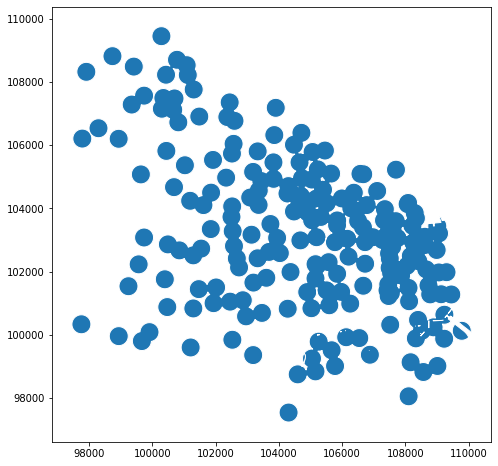

In [65]:
interseccion.dissolve(by="const").plot(figsize=(15,8), edgecolor='white'); 

In [66]:
area_de_cobertura = interseccion.dissolve(by="const")

In [67]:
# vemos que es una sola geometría
len(area_de_cobertura)

1

In [68]:
# de tipo multipolígono
area_de_cobertura.geometry

const
0    MULTIPOLYGON (((108630.246 99848.274, 108627.6...
Name: geometry, dtype: geometry

In [69]:
area_de_cobertura

,geometry,nombre_estacion,id_estacion,capacidad,dirección_completa,direccion_nombre,direccion_altura,direccion_interseccion,barrio,BARRIOS,PERIMETRO,AREA,COMUNAS,ID,OBJETO
const,,,,,,,,,,,,,,,
0,"MULTIPOLYGON (((108630.246 99848.274, 108627.6...",002 - Retiro I,2,20,"Ramos Mejia, Jose Maria, Dr. Av. & Del Liberta...","Ramos Mejia, Jose Maria, Dr. Av.",295.0,Del Libertador Av.,Retiro,CONSTITUCION - MONSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1.0,14,LIMITE COMUNAL


In [70]:
area_de_cobertura.geometry.area.values[0]

45318354.900141895

In [71]:
km2_cobertura = area_de_cobertura.geometry.area.values[0]/1000000
print("El área cubierta dentro de un buffer de 300 metros es de %r km2"%km2_cobertura)

El área cubierta dentro de un buffer de 300 metros es de 45.3183549001419 km2


In [72]:
porcentaje_cub = round(area_de_cobertura.geometry.area/comunas.geometry.area.sum()*100,2).values[0]
print("Lo que representa un total del {}% respecto del área total de la ciudad".format(porcentaje_cub))

Lo que representa un total del 22.21% respecto del área total de la ciudad


También podríamos haber calculado el área no cubierta dentro de un buffer de 300mts a las estaciones de EcoBici. Para eso, la operación a ser utilizada hubiese sido `difference` en lugar de `intersect`.

In [73]:
diferencia = gpd.overlay(comunas.to_crs(proj), estaciones_buff, how = "difference")

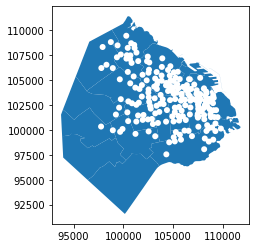

In [74]:
# aca vemos el area no cubierta
diferencia.plot();

In [75]:
diferencia["const"] = 0
area_no_cubierta = diferencia.dissolve(by='const')

In [76]:
km2_no_cubierta = area_no_cubierta.geometry.area.values[0]/1000000
print("El área cubierta dentro de un buffer de 300 metros es de %r km2"%km2_no_cubierta)

El área cubierta dentro de un buffer de 300 metros es de 158.75036213048227 km2


In [77]:
porcentaje_des = round(area_no_cubierta.geometry.area/comunas.geometry.area.sum()*100,2).values[0]
print("Lo que representa un total del {}% respecto del área total de la ciudad".format(porcentaje_des))

Lo que representa un total del 77.79% respecto del área total de la ciudad


In [78]:
# el area de la ciudad
porcentaje_cub + porcentaje_des

100.0